<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span></li><li><span><a href="#Are-all-libraries-that-are-needed-available?" data-toc-modified-id="Are-all-libraries-that-are-needed-available?-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Are all libraries that are needed available?</a></span></li><li><span><a href="#Prepare-an-image-provider-class" data-toc-modified-id="Prepare-an-image-provider-class-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Prepare an image provider class</a></span></li><li><span><a href="#Build-a-Convolutional-Neural-Network-(CNN)" data-toc-modified-id="Build-a-Convolutional-Neural-Network-(CNN)-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Build a Convolutional Neural Network (CNN)</a></span></li><li><span><a href="#Training-the-CNN" data-toc-modified-id="Training-the-CNN-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Training the CNN</a></span></li></ul></div>

# Introduction

The goal of this notebook is to show you how to build a simple Convolutional Neural Network (CNN) for classification in Keras.

For this, first we need data! Search for open datasets of free images that show cars and bikes. E.g., Google has published the Open Image Dataset V4:

https://storage.googleapis.com/openimages/web/visualizer/index.htm

Prepare a folder data with two subfolders:
    car
    bike
and store some hundreds of training images for each object category in each of these folders.


# Are all libraries that are needed available?

In [46]:
import numpy as np
import tensorflow as tf
import keras
import cv2
import matplotlib
import matplotlib.pyplot as plt

print( "Your NumPy version is:      " + np.__version__ )
print( "Your TensorFlow version is: " + tf.__version__)
print( "Your Keras version is:      " + keras.__version__ )
print( "Your OpenCV version is:     " + cv2.__version__ )
print( "Your Matplotlib version is: " + matplotlib.__version__)

Your NumPy version is:      1.16.2
Your TensorFlow version is: 1.13.1
Your Keras version is:      2.2.4
Your OpenCV version is:     4.1.0
Your Matplotlib version is: 2.0.2


# Prepare an image provider class

We define a class ``image_provider`` that will give us a convenient access to the images.

Given a root folder (e.g. "C:\\data"), it automatically determines which subfolders are there (e.g. "C:\\data\\car" and "C:\\data\\bike"). Each subfolder is assumed to be one of the categories we are interested in (e.g. "car" and "bike").

An image provide object then stores a list of all training items:
    
        [filename1, class_id, class_name, teacher_vec]
        [filename2, class_id, class_name, teacher_vec]
        ...

In [42]:
import os
from os import listdir
from os.path import isdir, isfile, join

IMG_SIZE = (100,100)
    
class image_provider:
    
    #
    # Traverses all subfolders of the specified root_folder
    # and generates a list of the form:
    #
    # [ ["data/bikes/jfksdj43.jpg", "bikes",
    #   ["data/cars/bvcnm401.jpg", "cars"],
    #   ...
    # ]
    #
    def __init__(self, root_folder):
        
        self.all_training_items = []
       
        class_names = \
            [d for d in listdir(root_folder)
             if isdir(os.path.join(root_folder,d))]

        print("Under folder\n\t", root_folder,
              "\nI found the following subfolders/classes:")
        print(class_names)
        
        self.nr_classes = len(class_names)
        
        # For each subfolder ...
        for class_id, class_name in enumerate(class_names):
            
            subfolder_name = root_folder + "/" + class_name + "/"
            
            filenames = \
                [subfolder_name + f
                 for f in listdir(subfolder_name) if isfile(join(subfolder_name, f))]
            
            print("{} files in subfolder {}".format(len(filenames), subfolder_name) )
            
            # For each image filename in current subfolder ...
            for filename in filenames:
                
                teacher_vec = np.zeros( self.nr_classes )
                teacher_vec[class_id] = 1.0
                
                self.all_training_items.append(
                    [filename, class_id, class_name, teacher_vec] )              
        
        self.nr_images = len(self.all_training_items)
        print("There are {} images in total available.".format(self.nr_images))
        
        print("Here are the first 3 entries of the training items list generated:")
        print(self.all_training_items[:3])
        
    
    
    #   
    # Given an absolute filename,
    # load the image in using OpenCV,
    # then convert it to usual RGB color channel order
    # and scale values to be in range [0,1]
    #
    def load_image(self, absolute_filename):
        
        image = cv2.imread(absolute_filename)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                
        image = cv2.resize(image, IMG_SIZE, interpolation=cv2.INTER_AREA)
        image = image * (1.0 / 255.0)
        
        return image
        
        
       
    #
    # Return the image from the dataset
    # with the specified index
    #
    def get_specific_image(self, idx):
        
        image_filename  = self.all_training_items[idx][0]
        class_id        = self.all_training_items[idx][1]
        class_name      = self.all_training_items[idx][2]
        teacher_vec     = self.all_training_items[idx][3]
        
        image = self.load_image(image_filename)
        
        return image, class_id, class_name, teacher_vec
    
    
    #
    # Return an OpenCV image and the class label
    # where the image is chosen randomly from the
    # list of all images.
    #
    def get_random_image(self):
        
        rnd_idx = np.random.randint(0, self.nr_images)
        return self.get_specific_image( rnd_idx )

Let's test the image provider class:

In [43]:
my_image_provider = image_provider( "V:\\01_job\\12_datasets\\01_imagenet_cars_vs_bikes" )

Under folder
	 V:\01_job\12_datasets\01_imagenet_cars_vs_bikes 
I found the following subfolders/classes:
['bikes', 'cars']
1344 files in subfolder V:\01_job\12_datasets\01_imagenet_cars_vs_bikes/bikes/
1307 files in subfolder V:\01_job\12_datasets\01_imagenet_cars_vs_bikes/cars/
There are 2651 images in total available.
Here are the first 3 entries of the training items list generated:
[['V:\\01_job\\12_datasets\\01_imagenet_cars_vs_bikes/bikes/n02834778_10.JPEG', 0, 'bikes', array([1., 0.])], ['V:\\01_job\\12_datasets\\01_imagenet_cars_vs_bikes/bikes/n02834778_10025.JPEG', 0, 'bikes', array([1., 0.])], ['V:\\01_job\\12_datasets\\01_imagenet_cars_vs_bikes/bikes/n02834778_10027.JPEG', 0, 'bikes', array([1., 0.])]]


Let us retrieve randomly one of the images and display it.

image has type <class 'numpy.ndarray'>
image has shape (100, 100, 3)
teacher vec: [1. 0.]


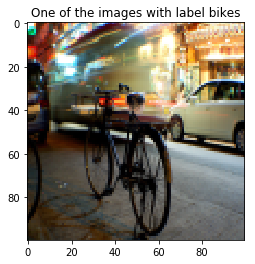

In [44]:
image, class_id, class_name, teacher_vec = \
    my_image_provider.get_random_image()
    
THE_INPUT_IMG_SHAPE = image.shape
    
print("image has type", type(image))
print("image has shape", image.shape)
print("teacher vec:", teacher_vec)
plt.imshow(image)
plt.title("One of the images with label {}".format(class_name))
plt.show()

# Build a Convolutional Neural Network (CNN)

Now we define a simple CNN in Keras.

What we need to specify is the input shape of a single image:

    (image_height, image_width, nr_color_channels)
    
Further, we need to specify how many output neurons the CNN shall have. This corresponds to the number of object classes we want to discriminate (classifiy) with the CNN:

    e.g., nr_output_neurons = 2 ("car" vs. "bike")
    e.g., nr_output_neurons = 3 ("car" vs. "bike" vs. "truck")
    
And then there are a lot of "hyperparameters" (model parameters we have to set manually):

- how many conv layers?
- how many pooling layers?
- order of layers?
- for each conv layer:
  - nr of filters?
  - kernel side length?
  - kernel stride?
  - activation function to use?
- for each max-pooling layer:
  - kernel side length?
  - kernel stride?
- for the final MLP at the end:
  - nr of layers?
  - for each MLP layer:
    - nr of neurons?
    - activation function to use?

In [51]:
from keras.utils import to_categorical
from keras import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.models import load_model
from keras import backend as K

def build_cnn_model(input_shape_of_single_image, nr_output_neurons):

    model = Sequential()

    # 1. Define the feature hierarchy:
    
    # Layer 1
    nr_filter       = 32
    kernel_side_len = 4
    kernel_stride   = 2
    model.add(Conv2D(nr_filter,
                     kernel_size=(kernel_side_len, kernel_side_len),
                     strides=(kernel_stride, kernel_stride),
                     activation='relu',
                     input_shape=input_shape_of_single_image)
             )
    
    # Layer 2
    kernel_side_len = 2
    kernel_stride   = 2
    model.add(MaxPooling2D(pool_size=(kernel_side_len, kernel_side_len),
                           strides=(kernel_stride, kernel_stride))
             )

    # 2. Define the MLP part:
    model.add(Flatten())
    model.add(Dense(nr_output_neurons, activation='softmax'))

    return model

# end build_a_cnn_model



# 1. Clear the last Keras session
#    This will clear the underlying TensorFlow graph
K.clear_session()


# 2. Create a CNN model
my_cnn = build_cnn_model(THE_INPUT_IMG_SHAPE, my_image_provider.nr_classes)


# 3. Show the model
my_cnn.summary()


# 4. Build model and configure model for training
my_cnn.compile(optimizer='adam', loss='categorical_crossentropy')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 49, 49, 32)        1568      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 36866     
Total params: 38,434
Trainable params: 38,434
Non-trainable params: 0
_________________________________________________________________


# Training the CNN

Now we will train the CNN. We will use "Stochastic Gradient Descent" (SGD) with just one training image per training step for the sake of simplicity (corresponds to mini batch with batch size 1). 

But note, that training could also be done using the "mini batch" approach. This means that in each training step we approximate the gradient for gradient descent step using e.g. 16,32,or 64 images.

This is normally much faster, however, it also means that we have to put all the images in one large 4D training array (img_nr, img_height, img_width, nr_channels). And this can make problems when we have a large dataset due to out-of-memory errors on the GPU or CPU being used.

In [54]:
nr_train_steps = 1000

height      = THE_INPUT_IMG_SHAPE[0]
width       = THE_INPUT_IMG_SHAPE[1]
nr_channels = THE_INPUT_IMG_SHAPE[2]

X = np.zeros( (1,height,width,nr_channels)     )
Y = np.zeros( (1,my_image_provider.nr_classes) )

for train_step in range(0,nr_train_steps):
    
    print("training step ", train_step)
    
    # 1. get the next random image from the dataset
    image, class_id, class_name, teacher_vec = \
        my_image_provider.get_random_image()
        
    # 2. put the image into a 4D array
    #    note: Keras expects a 4D array as input for
    #          the training function fit()
    X[0,:,:,:] = image
    
    # 3. the teacher value array expected by Keras
    #    is a 2D array
    Y[0,:] = teacher_vec
    
        
    # 3. train the model using this image    
    my_cnn.fit(X,Y)

training step  0
Epoch 1/1
1/1 [==============================] - 0s 4ms/step - loss: 0.3422
training step  1
Epoch 1/1
1/1 [==============================] - 0s 4ms/step - loss: 2.7978
training step  2
Epoch 1/1
1/1 [==============================] - 0s 6ms/step - loss: 0.2042
training step  3
Epoch 1/1
1/1 [==============================] - 0s 4ms/step - loss: 0.5085
training step  4
Epoch 1/1
1/1 [==============================] - 0s 4ms/step - loss: 1.7387
training step  5
Epoch 1/1
1/1 [==============================] - 0s 5ms/step - loss: 0.0982
training step  6
Epoch 1/1
1/1 [==============================] - 0s 4ms/step - loss: 0.3435
training step  7
Epoch 1/1
1/1 [==============================] - 0s 5ms/step - loss: 0.4001
training step  8
Epoch 1/1
1/1 [==============================] - 0s 6ms/step - loss: 0.5507
training step  9
Epoch 1/1
1/1 [==============================] - 0s 5ms/step - loss: 0.3085
training step  10
Epoch 1/1
1/1 [==============================] - 0s 

1/1 [==============================] - 0s 4ms/step - loss: 0.5456
training step  88
Epoch 1/1
1/1 [==============================] - 0s 5ms/step - loss: 0.7003
training step  89
Epoch 1/1
1/1 [==============================] - 0s 5ms/step - loss: 1.0401
training step  90
Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 0.2495
training step  91
Epoch 1/1
1/1 [==============================] - 0s 4ms/step - loss: 0.3606
training step  92
Epoch 1/1
1/1 [==============================] - 0s 4ms/step - loss: 0.4866
training step  93
Epoch 1/1
1/1 [==============================] - 0s 4ms/step - loss: 0.3098
training step  94
Epoch 1/1
1/1 [==============================] - 0s 4ms/step - loss: 0.2268
training step  95
Epoch 1/1
1/1 [==============================] - 0s 6ms/step - loss: 0.2507
training step  96
Epoch 1/1
1/1 [==============================] - 0s 4ms/step - loss: 0.5043
training step  97
Epoch 1/1
1/1 [==============================] - 0s 6ms/step - loss: 0

training step  174
Epoch 1/1
1/1 [==============================] - 0s 4ms/step - loss: 0.9072
training step  175
Epoch 1/1
1/1 [==============================] - 0s 4ms/step - loss: 0.1596
training step  176
Epoch 1/1
1/1 [==============================] - 0s 5ms/step - loss: 0.1091
training step  177
Epoch 1/1
1/1 [==============================] - 0s 5ms/step - loss: 0.6332
training step  178
Epoch 1/1
1/1 [==============================] - 0s 5ms/step - loss: 0.0402
training step  179
Epoch 1/1
1/1 [==============================] - 0s 5ms/step - loss: 0.4588
training step  180
Epoch 1/1
1/1 [==============================] - 0s 4ms/step - loss: 0.0120
training step  181
Epoch 1/1
1/1 [==============================] - 0s 4ms/step - loss: 0.3965
training step  182
Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 1.9657
training step  183
Epoch 1/1
1/1 [==============================] - 0s 4ms/step - loss: 0.0433
training step  184
Epoch 1/1
1/1 [================

training step  261
Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 0.0457
training step  262
Epoch 1/1
1/1 [==============================] - 0s 5ms/step - loss: 0.3983
training step  263
Epoch 1/1
1/1 [==============================] - 0s 5ms/step - loss: 0.1151
training step  264
Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 0.4119
training step  265
Epoch 1/1
1/1 [==============================] - 0s 4ms/step - loss: 0.6150
training step  266
Epoch 1/1
1/1 [==============================] - 0s 5ms/step - loss: 0.0162
training step  267
Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 0.4473
training step  268
Epoch 1/1
1/1 [==============================] - 0s 5ms/step - loss: 0.0059
training step  269
Epoch 1/1
1/1 [==============================] - 0s 6ms/step - loss: 0.0357
training step  270
Epoch 1/1
1/1 [==============================] - 0s 4ms/step - loss: 0.0775
training step  271
Epoch 1/1
1/1 [================

training step  348
Epoch 1/1
1/1 [==============================] - 0s 4ms/step - loss: 2.9883
training step  349
Epoch 1/1
1/1 [==============================] - 0s 4ms/step - loss: 0.2118
training step  350
Epoch 1/1
1/1 [==============================] - 0s 4ms/step - loss: 0.0362
training step  351
Epoch 1/1
1/1 [==============================] - 0s 4ms/step - loss: 0.5557
training step  352
Epoch 1/1
1/1 [==============================] - 0s 4ms/step - loss: 1.2569
training step  353
Epoch 1/1
1/1 [==============================] - 0s 4ms/step - loss: 0.5395
training step  354
Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 0.1660
training step  355
Epoch 1/1
1/1 [==============================] - 0s 5ms/step - loss: 0.1194
training step  356
Epoch 1/1
1/1 [==============================] - 0s 4ms/step - loss: 0.8298
training step  357
Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 0.0134
training step  358
Epoch 1/1
1/1 [================

training step  435
Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 0.1597
training step  436
Epoch 1/1
1/1 [==============================] - 0s 4ms/step - loss: 0.0300
training step  437
Epoch 1/1
1/1 [==============================] - 0s 5ms/step - loss: 0.2503
training step  438
Epoch 1/1
1/1 [==============================] - 0s 5ms/step - loss: 0.1927
training step  439
Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 0.0269
training step  440
Epoch 1/1
1/1 [==============================] - 0s 4ms/step - loss: 0.0076
training step  441
Epoch 1/1
1/1 [==============================] - 0s 5ms/step - loss: 2.1638
training step  442
Epoch 1/1
1/1 [==============================] - 0s 4ms/step - loss: 0.0628
training step  443
Epoch 1/1
1/1 [==============================] - 0s 6ms/step - loss: 0.3327
training step  444
Epoch 1/1
1/1 [==============================] - 0s 4ms/step - loss: 0.0024
training step  445
Epoch 1/1
1/1 [================

training step  522
Epoch 1/1
1/1 [==============================] - 0s 5ms/step - loss: 0.1201
training step  523
Epoch 1/1
1/1 [==============================] - 0s 4ms/step - loss: 0.2747
training step  524
Epoch 1/1
1/1 [==============================] - 0s 4ms/step - loss: 0.1964
training step  525
Epoch 1/1
1/1 [==============================] - 0s 6ms/step - loss: 0.1267
training step  526
Epoch 1/1
1/1 [==============================] - 0s 4ms/step - loss: 0.4670
training step  527
Epoch 1/1
1/1 [==============================] - 0s 4ms/step - loss: 0.0889
training step  528
Epoch 1/1
1/1 [==============================] - 0s 5ms/step - loss: 0.0214
training step  529
Epoch 1/1
1/1 [==============================] - 0s 5ms/step - loss: 0.3176
training step  530
Epoch 1/1
1/1 [==============================] - 0s 6ms/step - loss: 0.0999
training step  531
Epoch 1/1
1/1 [==============================] - 0s 4ms/step - loss: 0.4532
training step  532
Epoch 1/1
1/1 [================

Epoch 1/1
1/1 [==============================] - 0s 5ms/step - loss: 3.3131
training step  609
Epoch 1/1
1/1 [==============================] - 0s 4ms/step - loss: 0.0456
training step  610
Epoch 1/1
1/1 [==============================] - 0s 4ms/step - loss: 0.1401
training step  611
Epoch 1/1
1/1 [==============================] - 0s 6ms/step - loss: 1.2353
training step  612
Epoch 1/1
1/1 [==============================] - 0s 5ms/step - loss: 0.0032
training step  613
Epoch 1/1
1/1 [==============================] - 0s 4ms/step - loss: 0.0115
training step  614
Epoch 1/1
1/1 [==============================] - 0s 5ms/step - loss: 1.6732
training step  615
Epoch 1/1
1/1 [==============================] - 0s 5ms/step - loss: 0.0046
training step  616
Epoch 1/1
1/1 [==============================] - 0s 5ms/step - loss: 0.1939
training step  617
Epoch 1/1
1/1 [==============================] - 0s 4ms/step - loss: 0.0668
training step  618
Epoch 1/1
1/1 [==============================] - 0

training step  695
Epoch 1/1
1/1 [==============================] - 0s 4ms/step - loss: 0.2560
training step  696
Epoch 1/1
1/1 [==============================] - 0s 4ms/step - loss: 0.0064
training step  697
Epoch 1/1
1/1 [==============================] - 0s 4ms/step - loss: 1.9400
training step  698
Epoch 1/1
1/1 [==============================] - 0s 5ms/step - loss: 0.7561
training step  699
Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 0.0601
training step  700
Epoch 1/1
1/1 [==============================] - 0s 5ms/step - loss: 0.4699
training step  701
Epoch 1/1
1/1 [==============================] - 0s 5ms/step - loss: 0.0510
training step  702
Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 0.0863
training step  703
Epoch 1/1
1/1 [==============================] - 0s 4ms/step - loss: 0.3938
training step  704
Epoch 1/1
1/1 [==============================] - 0s 4ms/step - loss: 0.0106
training step  705
Epoch 1/1
1/1 [================

1/1 [==============================] - 0s 4ms/step - loss: 0.1601
training step  782
Epoch 1/1
1/1 [==============================] - 0s 4ms/step - loss: 0.0207
training step  783
Epoch 1/1
1/1 [==============================] - 0s 4ms/step - loss: 0.3708
training step  784
Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 0.1753
training step  785
Epoch 1/1
1/1 [==============================] - 0s 5ms/step - loss: 1.0232
training step  786
Epoch 1/1
1/1 [==============================] - 0s 4ms/step - loss: 0.2452
training step  787
Epoch 1/1
1/1 [==============================] - 0s 4ms/step - loss: 0.5328
training step  788
Epoch 1/1
1/1 [==============================] - 0s 4ms/step - loss: 0.0104
training step  789
Epoch 1/1
1/1 [==============================] - 0s 4ms/step - loss: 0.1337
training step  790
Epoch 1/1
1/1 [==============================] - 0s 4ms/step - loss: 0.0374
training step  791
Epoch 1/1
1/1 [==============================] - 0s 4ms/step

training step  868
Epoch 1/1
1/1 [==============================] - 0s 6ms/step - loss: 0.2795
training step  869
Epoch 1/1
1/1 [==============================] - 0s 4ms/step - loss: 0.0275
training step  870
Epoch 1/1
1/1 [==============================] - 0s 4ms/step - loss: 0.3983
training step  871
Epoch 1/1
1/1 [==============================] - 0s 4ms/step - loss: 0.0071
training step  872
Epoch 1/1
1/1 [==============================] - 0s 5ms/step - loss: 0.4714
training step  873
Epoch 1/1
1/1 [==============================] - 0s 4ms/step - loss: 0.6083
training step  874
Epoch 1/1
1/1 [==============================] - 0s 4ms/step - loss: 0.0105
training step  875
Epoch 1/1
1/1 [==============================] - 0s 6ms/step - loss: 1.2031
training step  876
Epoch 1/1
1/1 [==============================] - 0s 5ms/step - loss: 0.0074
training step  877
Epoch 1/1
1/1 [==============================] - 0s 4ms/step - loss: 0.2017
training step  878
Epoch 1/1
1/1 [================

training step  955
Epoch 1/1
1/1 [==============================] - 0s 4ms/step - loss: 0.2519
training step  956
Epoch 1/1
1/1 [==============================] - 0s 4ms/step - loss: 0.0151
training step  957
Epoch 1/1
1/1 [==============================] - 0s 4ms/step - loss: 0.1153
training step  958
Epoch 1/1
1/1 [==============================] - 0s 6ms/step - loss: 0.4011
training step  959
Epoch 1/1
1/1 [==============================] - 0s 4ms/step - loss: 0.6836
training step  960
Epoch 1/1
1/1 [==============================] - 0s 4ms/step - loss: 0.7242
training step  961
Epoch 1/1
1/1 [==============================] - 0s 4ms/step - loss: 0.0066
training step  962
Epoch 1/1
1/1 [==============================] - 0s 4ms/step - loss: 0.1286
training step  963
Epoch 1/1
1/1 [==============================] - 0s 6ms/step - loss: 0.3414
training step  964
Epoch 1/1
1/1 [==============================] - 0s 4ms/step - loss: 0.0096
training step  965
Epoch 1/1
1/1 [================